## Initial data modelling

In [6]:
%load_ext autoreload
%autoreload 2
from data_utils import EM_DATA
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IPython.display import Image as IPImage
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
%matplotlib inline

### Dataloaders
See the data_utils file for logic. Does not transform the validation data

In [7]:
transform = transforms.Compose([transforms.ToTensor()])
# Load the dataset
train_dataset = EM_DATA(train=True, size=256, _transform=transform, data_path="Data")
test_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="Data")
validation_dataset = EM_DATA(train=False, size=256, _transform=transform, data_path="Data", validation=True)

### Data examples

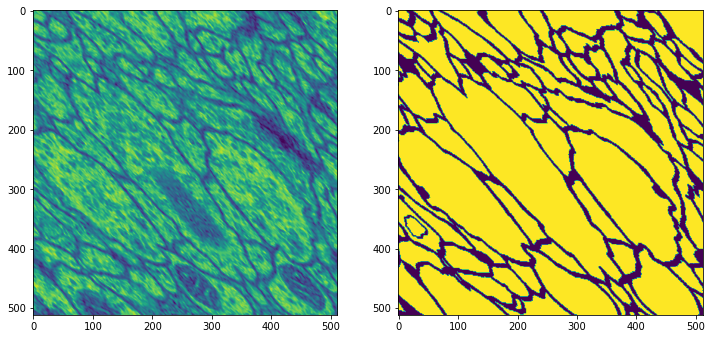

In [23]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(12,12))

data_ex=next(iter(train_dataset))

ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

## Model training and testing

In [66]:
from model import UNet
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np
# Depth describes levels of unet - default is 5
model = UNet(1, in_channels=1, depth=2, merge_mode='concat')
def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(100)

# Test it works
x = Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
out = model(x)
loss = torch.sum(out)
loss.backward()

In [67]:
print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Model parameters:  402625


## Optimizer

In [68]:
learning_rate = 0.8e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=4e-3)

## Loss

In [69]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

criterion = DiceLoss()

## Training

Helper functions for plotting

In [ ]:
def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
    """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

    grid = torchvision.utils.make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
    npgrid = grid.cpu().numpy()

    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if not (title == ''):
        plt.title(title)

    plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)
    plt.clf()

# Example usage
# plot_images_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0), 'test.png')

In [70]:
from datetime import datetime

In [71]:
CUDA=False

In [72]:
set_seed(100)
SAVE_CHECKPOINTS = False

num_epochs = 20
itr = 0
# Save loss for plot
training_loss=[]
validation_loss=[]

print("Start Iter")

# Status parameters
global_steps=0

# Monitoring
t1=datetime.now()
t2=datetime.now()
for epoch in range(num_epochs):
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.eval()
    # For grid in validation set
    for inputs,targets in validation_dataset:
        inputs=inputs.unsqueeze(0)
        targets=targets.unsqueeze(0)
        # Add channel
        if CUDA:
            inputs = inputs.cuda()
            targets = targets.cuda()

        # Forward pass to get output/logits
        y_hat = model(x)
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y_hat,targets)

        # Getting gradients w.r.t. parameters
        epoch_validation_loss += loss.cpu().detach().numpy()
        
    model.train()
    # For grid in traning set
    for inputs,targets in train_dataset:
        inputs=inputs.unsqueeze(0)
        targets=targets.unsqueeze(0)
        # Add channel
        if CUDA:
            inputs = inputs.cuda()
            targets = targets.cuda()

        # Forward pass to get output/logits
        y_hat = model(x)
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y_hat, targets)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        
        # Step taken
        global_steps+=1
        
    # Save every epoch
    if SAVE_CHECKPOINTS:
        model_name=f'./checkpoint_saves/{type(model).__name__}_{type(criterion).__name__}_checkpoint_epoch_{epoch}_{datetime.now()}'
        # Send dict to memory
        torch.save(model.state_dict(), model_name)
        
    # Early breaking if validationloss increases 3 times
    if len(validation_loss)>3:
        if (validation_loss[-1]>=validation_loss[-2]) and (validation_loss[-1]>=validation_loss[-3]) and (validation_loss[-1]>=validation_loss[-4]):
            break
    # Save loss for plot
    training_loss.append(epoch_training_loss)
    validation_loss.append(epoch_validation_loss)
    print(f"Epoch {epoch}\nTraning loss: {epoch_training_loss}\nValidation loss{epoch_validation_loss}")

Start Iter
0:00:00.000047


KeyboardInterrupt: 

In [121]:
npgrid=torchvision.utils.make_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0))
print(npgrid.shape)

torch.Size([3, 516, 1544])


In [122]:
np.transpose(npgrid, (1, 2, 0)).shape

torch.Size([516, 1544, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


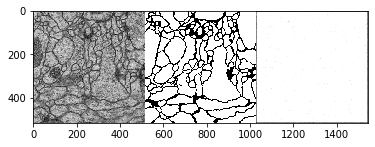

In [123]:
plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')